In [21]:
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

from time import time
from sph_lib.interpolation import sph_interpolator
from sph_lib.utils import create_grid_3d
plt.style.use('../../mnras')

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Data loading

In [22]:
ds = pn.load('../../../data/snapshot_176_128.hdf5')
boxsize = 15000

# base numbers
Nx = 128
NN = 64

pos    = ds.gas['pos']
masses = ds.gas['mass']
temp   = ds.gas['temp']
vel    = ds.gas['vel'][:, 0]

/opt/anaconda3/envs/my_env/lib/python3.12/site-packages/pynbody/snapshot/gadgethdf.py:635: RuntimeWarning: No unit information found in GadgetHDF file. Using gadget default units.
  warnings.warn("No unit information found in GadgetHDF file. Using gadget default units.", RuntimeWarning)
/opt/anaconda3/envs/my_env/lib/python3.12/site-packages/pynbody/snapshot/gadgethdf.py:469: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")


### Scaling vs number of neighbors

In [23]:
NNs = [2, 4, 8, 16, 64, 128]
times_nn = []

for nn in tqdm.tqdm(NNs):

    grid_3d = create_grid_3d(Nx, Nx, Nx, boxsize)
    s = time()
    
    Interpolator = sph_interpolator(pos, masses, boxsize, nn)
    ρ = Interpolator.rho
    fields_to_interpolate = [ρ, temp, vel]
    grids  = Interpolator.interpolate_fields_at_positions(fields_to_interpolate, grid_3d)
    
    e = time()
    times_nn.append(e-s)

  0%|          | 0/6 [00:00<?, ?it/s]

Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...


### Scaling vs number of query coordinates

In [24]:
Nxs = [4, 8, 16, 32, 64, 128]
times_nx = []

Interpolator = sph_interpolator(pos, masses, boxsize, NN)
ρ = Interpolator.rho
fields_to_interpolate = [ρ, temp, vel]

for nx in tqdm.tqdm(Nxs):

    grid_3d = create_grid_3d(nx, nx, nx, boxsize)
    s = time()
    grids  = Interpolator.interpolate_fields_at_positions(fields_to_interpolate, grid_3d)
    e = time()
    times_nx.append(e-s)

Computing 3d smoothing lengths and densities...


  0%|          | 0/6 [00:00<?, ?it/s]

### Scaling vs number of particles

In [25]:
Np = [1, 4, 16, 64, 256, 1024, 4096][::-1]
Nps = [len(pos) / np for np in Np]
times_np = []

for npp in tqdm.tqdm(Np):

    grid_3d = create_grid_3d(Nx, Nx, Nx, boxsize)
    s = time()

    pos_temp    = pos[::npp]
    masses_temp = masses[::npp]
    temp_temp   = temp[::npp]
    vel_temp    = vel[::npp]

    Interpolator = sph_interpolator(pos_temp, masses_temp, boxsize, NN)
    ρ = Interpolator.rho
    fields_to_interpolate = [ρ, temp_temp, vel_temp]
    grids  = Interpolator.interpolate_fields_at_positions(fields_to_interpolate, grid_3d)
    
    e = time()
    times_np.append(e-s)

  0%|          | 0/7 [00:00<?, ?it/s]

Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...


### Scaling vs kernel function

In [26]:
kernels = ['gaussian', 
           'super_gaussian', 
           'cubic_spline', 
           'quintic_spline', 
           'wendland_c2', 
           'wendland_c4', 
           'wendland_c6'
           ]
times_nk = []

for kernel in tqdm.tqdm(kernels):

    grid_3d = create_grid_3d(Nx, Nx, Nx, boxsize)
    s = time()

    Interpolator = sph_interpolator(pos_temp, masses_temp, boxsize, NN, kernel=kernel)
    ρ = Interpolator.rho
    fields_to_interpolate = [ρ, temp_temp, vel_temp]
    grids  = Interpolator.interpolate_fields_at_positions(fields_to_interpolate, grid_3d)
    
    e = time()
    times_nk.append(e-s)

  0%|          | 0/7 [00:00<?, ?it/s]

Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...
Computing 3d smoothing lengths and densities...


### Plotting of scalings

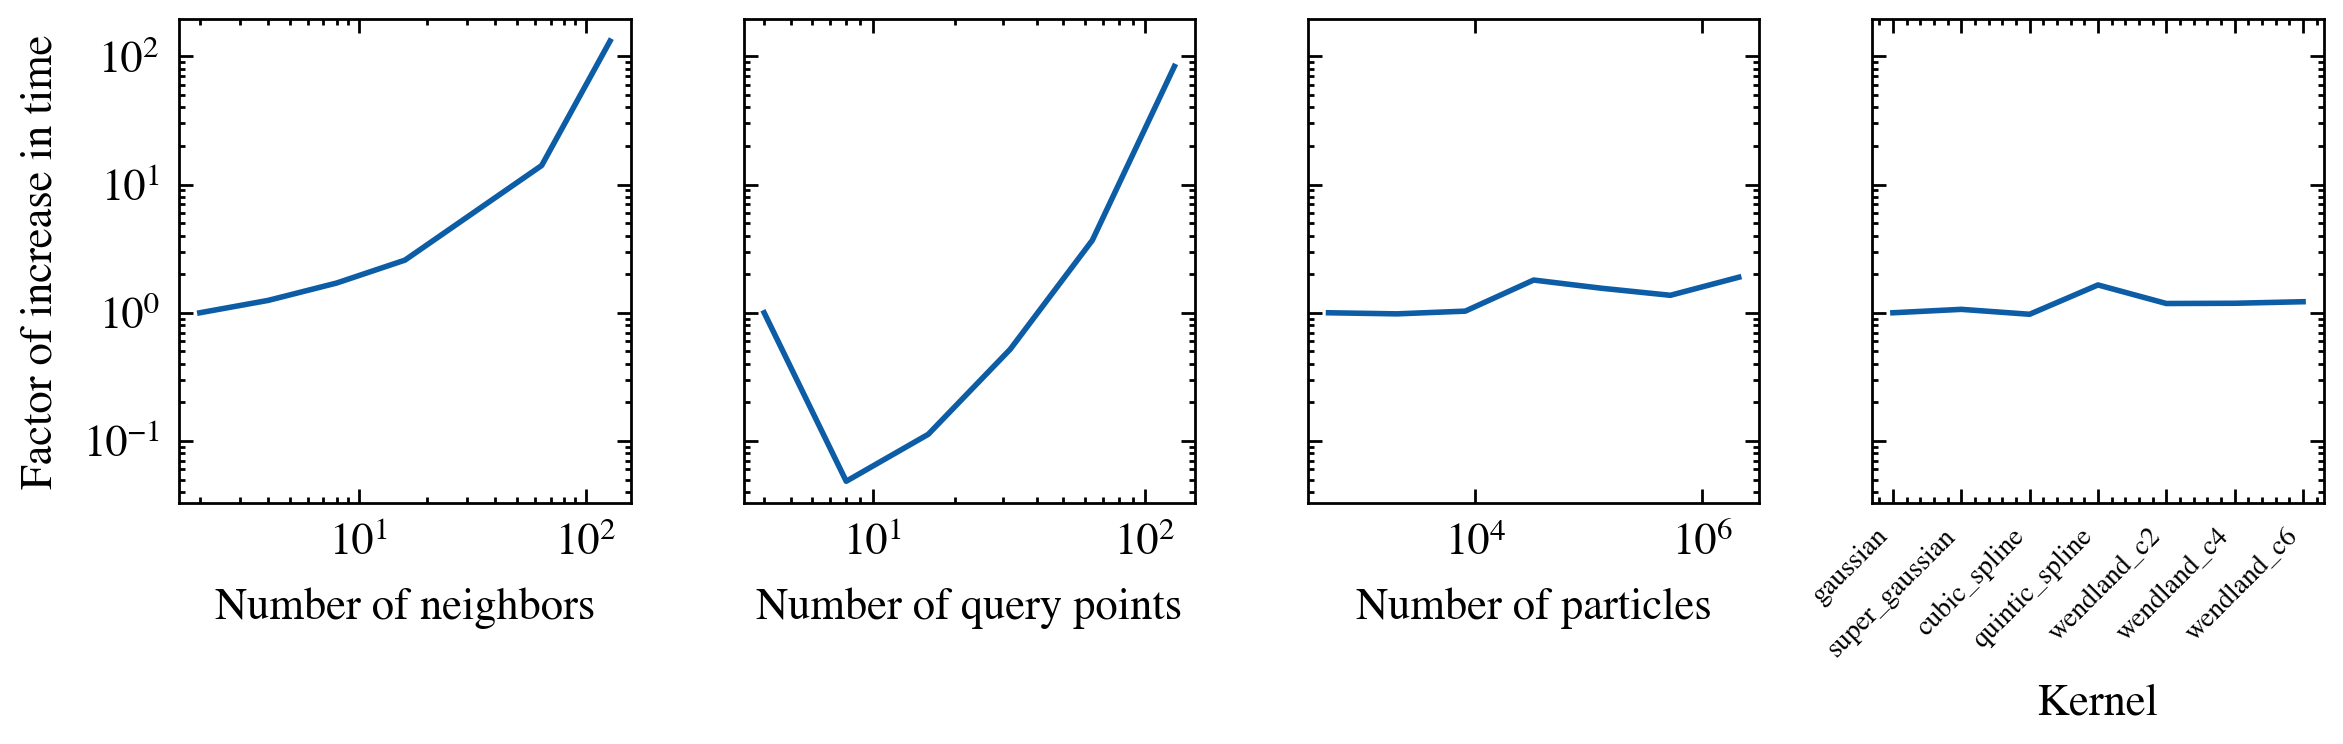

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(6, 2), sharey=True)

ax[0].loglog(NNs, np.asarray(times_nn) / times_nn[0])
ax[1].loglog(Nxs, np.asarray(times_nx) / times_nx[0])
ax[2].loglog(Nps, np.asarray(times_np) / times_np[0])
ax[3].semilogy(np.arange(len(kernels)), np.asarray(times_nk) / times_nk[0])

ax[0].set(
    xlabel='Number of neighbors',
    ylabel='Factor of increase in time'
)

ax[1].set(
    xlabel='Number of query points',
)

ax[2].set(
    xlabel='Number of particles',
)

ax[3].set(
    xlabel='Kernel',
)

# Properly assign the tick positions and labels
ax[3].set_xticks(np.arange(len(kernels)))
ax[3].set_xticklabels(kernels, rotation=45, fontsize=5)
for tick in ax[3].get_xticklabels():
    tick.set_ha('right')

plt.tight_layout()
plt.savefig('../figures/scalings_interpolation', dpi=300)
plt.show()